# Raster Data 2: Joint Land Use and Elevation


In [118]:
import numpy as np
import rasterio as rio
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter

elev_fname = '../data/ubrb_dem_30m.tif'
lulc_fname = '../data/upper_boise_landcover_30m.tif'

nlcd_cfile = './nlcd_classifications.csv'

In [119]:
def z_in_range(z_array, zmin, zmax):
    
    # 1. Create a masked array that is identical to z_array in dimensions,
    #    but where values outside zmin to zmax are masked
    z_ma = np.ma.masked_outside(z_array, zmin, zmax)
        
    # 2. Return the masked array
    return z_ma

In [120]:
def lulc_in_zrange(lulc_array_local,z_ma_local,lulc_bins_local):
    
    # 1. Get the LULC values within the elevation range mask given in z_ma
    lulc_ma = np.ma.masked_array(lulc_array_local, ~z_ma_local.mask)
    
    # 2. Get the histogram of LULC in lulc_ma
    lulc_1d = lulc_ma.data[lulc_ma.mask] # 1D vector of LULC not masked
    
    lulc_counts = np.zeros(lulc_bins_local.size)
    
    for i in np.arange(lulc_bins_local.size):
        lulc_counts[i] = np.count_nonzero(lulc_1d == lulc_bins_local[i])
    
    # 3. Return LULC histogram
    return lulc_counts
    

In [121]:
elev_data = rio.open(elev_fname)
elev_array = elev_data.read(1)

zmin = elev_array.min()
zmax = elev_array.max()
zmean = elev_array.mean()

zstats = f'''
Elevation Statistics:
Number of columns [east-west]: {elev_array.shape[1]} 
Number of rows [north-south]: {elev_array.shape[0]}
Minimum elevation: {zmin:.{2}f} m
Maximum elevation: {zmax:.{2}f} m
Mean elevation: {zmean:.{2}f} m
'''

print(zstats)


Elevation Statistics:
Number of columns [east-west]: 5433 
Number of rows [north-south]: 3239
Minimum elevation: 853.23 m
Maximum elevation: 3259.66 m
Mean elevation: 1797.45 m



In [122]:
lulc_data = rio.open(lulc_fname)
lulc_array = np.flipud(lulc_data.read(1))

lulc_bins = np.unique(lulc_array)

lulcstats = f'''
Land Use/Land Cover Present: {lulc_bins}
'''

print(lulcstats)


Land Use/Land Cover Present: [11 12 21 22 23 24 31 41 42 43 52 71 81 82 90 95]



#### X. Histogram Within 500 m of Mean Elevation


In [ ]:
zmin_hist = zmean - 250.0
zmax_hist = zmean + 250.0

z_mid_ma = z_in_range(elev_array, zmin_hist, zmax_hist)

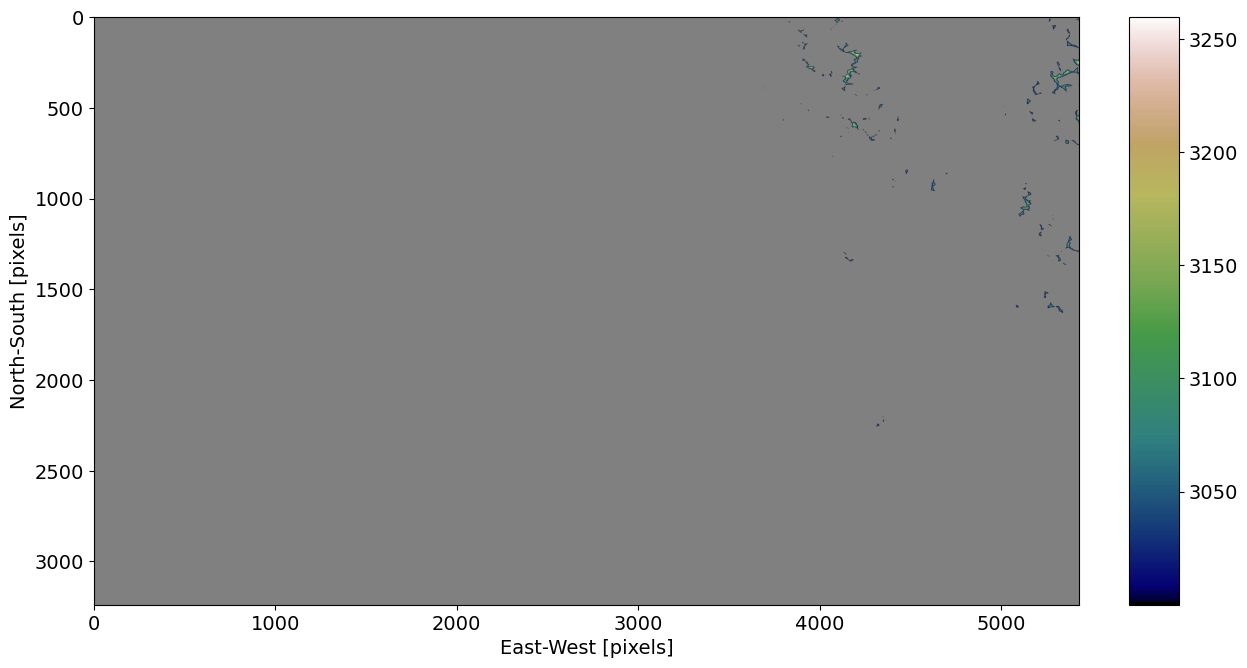

In [124]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize = (14,8))
im = ax.imshow(z_mid_ma,cmap='gist_earth')
ax.set_xlabel('East-West [pixels]')
ax.set_ylabel('North-South [pixels]')
ax.set_facecolor('gray')
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size = '5%', pad = 0.5, pack_start = False)
fig.add_axes(cax)
fig.colorbar(mappable=im, cax=cax)

plt.show()


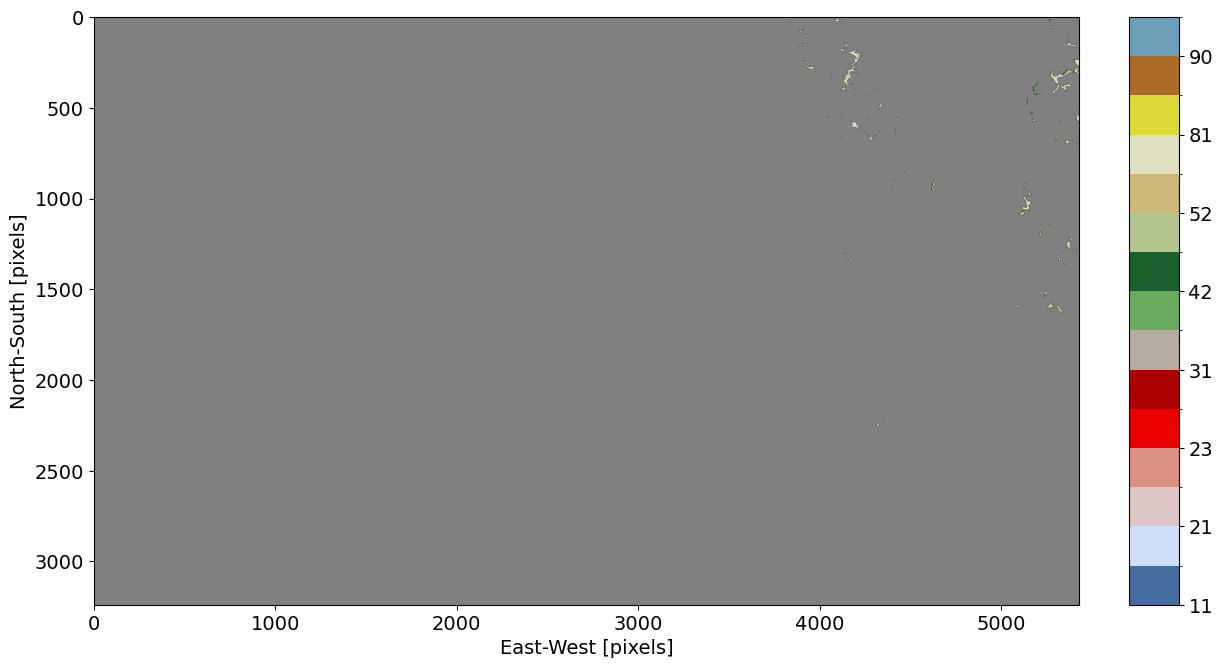

In [125]:
lulc_mid = np.ma.masked_array(lulc_array, z_mid_ma.mask)

# Create NLCD colormap using pygeohydro tool stack 
nlcd_df = pd.read_csv(nlcd_cfile)
cmap_nlcd = mcolors.ListedColormap(nlcd_df.color_code.values.astype(str),'nlcd_cmap')
norm_nlcd = mcolors.BoundaryNorm(lulc_bins, cmap_nlcd.N)

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize = (14,8))
im = ax.imshow(lulc_mid,cmap=cmap_nlcd, norm=norm_nlcd)
ax.set_xlabel('East-West [pixels]')
ax.set_ylabel('North-South [pixels]')
ax.set_facecolor('gray')
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size = '5%', pad = 0.5, pack_start = False)
fig.add_axes(cax)
fig.colorbar(mappable=im, cax=cax)

plt.show()

In [126]:
lulc_mid_counts = lulc_in_zrange(lulc_array,z_mid_ma,lulc_bins)

lulc_mid_freq = lulc_mid_counts / lulc_mid_counts.sum()


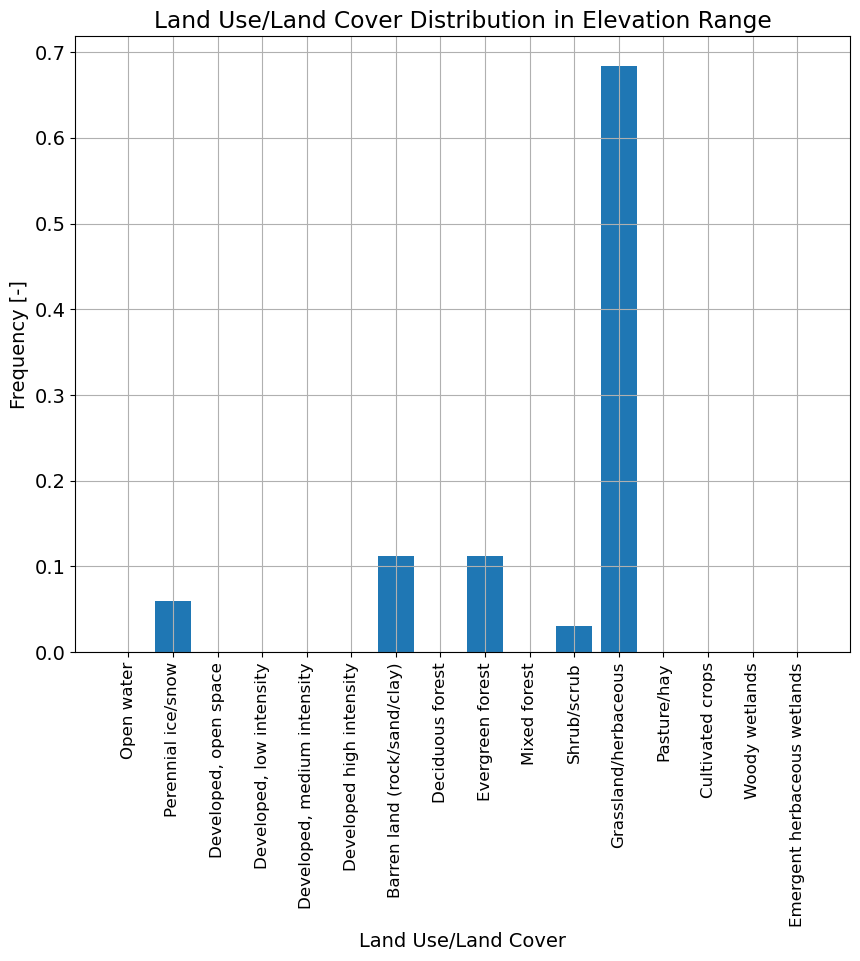

In [127]:
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(lulc_bins.astype(str),lulc_mid_freq)
ax.set_title('Land Use/Land Cover Distribution in Elevation Range')
ax.set_xlabel('Land Use/Land Cover')
ax.set_ylabel('Frequency [-]')
ax.set_xticks(nlcd_df.id.astype(str))
ax.set_xticklabels(nlcd_df.label_short.values, rotation=90, fontsize=12)
ax.grid('on')
plt.show()

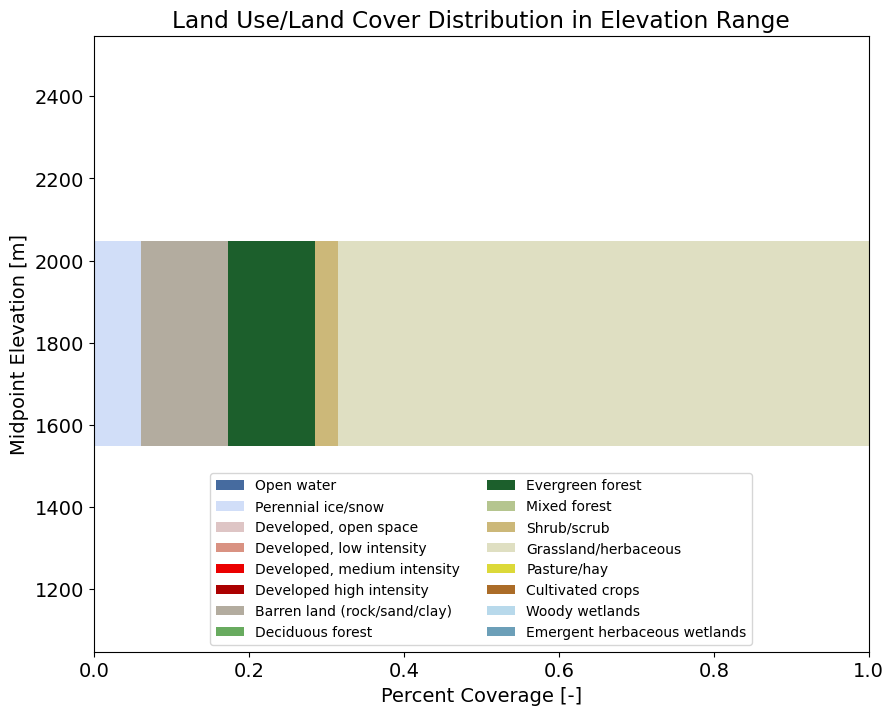

In [128]:

fig, ax = plt.subplots(figsize=(10,8))

left = 0.0

for i in np.arange(lulc_bins.size):
    ax.barh(zmean, lulc_mid_freq[i], left=left, height=500.0, color=cmap_nlcd.colors[i], label=nlcd_df.label_short.values[i])
    left += lulc_mid_freq[i]

ax.set_ylim([zmean-750.0,zmean+750.0])
ax.set_title('Land Use/Land Cover Distribution in Elevation Range')
ax.set_xlabel('Percent Coverage [-]')
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.set_ylabel('Midpoint Elevation [m]')
ax.legend(fontsize=10, ncol=2, loc='lower center')
plt.show()

In [129]:
lulc_mid_counts

array([   22.,  1717.,     0.,     0.,     0.,     0.,  3223.,     0.,
        3215.,     0.,   865., 19594.,     0.,     0.,     0.,     0.])